In [30]:
# Initial imports
import pandas as pd 
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import talib
from sklearn.linear_model import LinearRegression, LogisticRegression

In [2]:
# Get S&P500 symbols ranked by market cap 
sp500_by_marketcap = pd.read_csv('SP500_By_MarketCap.csv')
sp500_by_marketcap.head()

,Symbol,Name,Industry,Market Cap
0,AAPL,Apple Inc.,Electronic Technology,"$ 2,986,128,347,290.24"
1,MSFT,Microsoft Corporation,Technology Services,"$ 2,513,296,516,647.36"
2,GOOG,Alphabet Inc.,Technology Services,"$ 1,927,101,773,229.48"
3,GOOGL,Alphabet Inc.,Technology Services,"$ 1,923,705,624,039.54"
4,AMZN,"Amazon.com, Inc.",Retail Trade,"$ 1,728,404,755,739.39"


In [3]:
# Separate tickers 
tickers = sp500_by_marketcap['Symbol'].tolist()

In [4]:
# Set timeframe 
end = datetime.now()
start = (datetime.now() - timedelta(90))


In [5]:
# Get stock data from yfinance 
df_stock_data=pd.DataFrame()
for ticker in tickers:
    ticker_df = yf.download(ticker, start=start, end=end,interval="1D")
    ticker_df = ticker_df.reset_index()
    ticker_df["Stock"] = ticker
    # Creating a unique key by combining Ticker and Publish date
    ticker_df["unique_key"] = ticker_df["Stock"]+ticker_df["Date"].astype(str)
    #ticker_df.index = ticker_df.index.unique_key
    df_stock_data =pd.concat([df_stock_data,ticker_df],axis=0)
df_stock_data = df_stock_data.set_index("unique_key")
df_stock_data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BRK.B: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%**********

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
unique_key,,,,,,,,
AAPL2022-01-13,2022-01-13,175.779999,176.619995,171.789993,172.190002,171.970901,84505800.0,AAPL
AAPL2022-01-14,2022-01-14,171.339996,173.779999,171.089996,173.070007,172.849792,80440800.0,AAPL
AAPL2022-01-18,2022-01-18,171.509995,172.539993,169.410004,169.800003,169.583939,90956700.0,AAPL
AAPL2022-01-19,2022-01-19,170.000000,171.080002,165.940002,166.229996,166.018478,94815000.0,AAPL
AAPL2022-01-20,2022-01-20,166.979996,169.679993,164.179993,164.509995,164.300659,91420500.0,AAPL


In [6]:
# Create "Returns" column 
df_stock_data["Returns"] = (df_stock_data["Adj Close"] - df_stock_data["Open"])/df_stock_data["Open"]

# Drop "Close Column 
df_stock_data.drop(columns=['Close'],inplace=True)


In [7]:
df_stock_data.head()

,Date,Open,High,Low,Adj Close,Volume,Stock,Returns
unique_key,,,,,,,,
AAPL2022-01-13,2022-01-13,175.779999,176.619995,171.789993,171.970901,84505800.0,AAPL,-0.021670
AAPL2022-01-14,2022-01-14,171.339996,173.779999,171.089996,172.849792,80440800.0,AAPL,0.008812
AAPL2022-01-18,2022-01-18,171.509995,172.539993,169.410004,169.583939,90956700.0,AAPL,-0.011230
AAPL2022-01-19,2022-01-19,170.000000,171.080002,165.940002,166.018478,94815000.0,AAPL,-0.023421
AAPL2022-01-20,2022-01-20,166.979996,169.679993,164.179993,164.300659,91420500.0,AAPL,-0.016046


In [31]:
df_stock_data.tail()

,Date,Open,High,Low,Adj Close,Volume,Stock,Returns
unique_key,,,,,,,,
ALK2022-04-06,2022-04-06,55.400002,55.770000,53.480000,55.040001,2314400.0,ALK,-0.006498
ALK2022-04-07,2022-04-07,54.639999,54.639999,52.320000,53.400002,2139100.0,ALK,-0.022694
ALK2022-04-08,2022-04-08,53.470001,53.680000,52.189999,52.290001,1691400.0,ALK,-0.022068
ALK2022-04-11,2022-04-11,52.250000,54.040001,51.910000,52.820000,1474900.0,ALK,0.010909
ALK2022-04-12,2022-04-12,53.000000,53.959999,52.529999,53.450001,1344800.0,ALK,0.008491


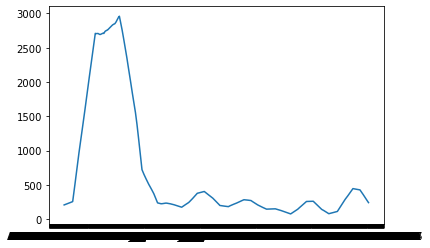

In [34]:
# Simple Moving Average for 90 day period
sma = talib.SMA(df_stock_data['Adj Close'], 90)

plt.plot(sma)

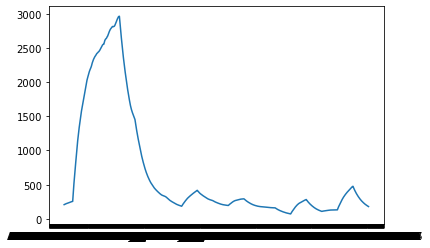

In [35]:
#Exponential Moving Average for 90 day period
ema = EMA(df_stock_data['Adj Close'], timeperiod=90)

plt.plot(ema)

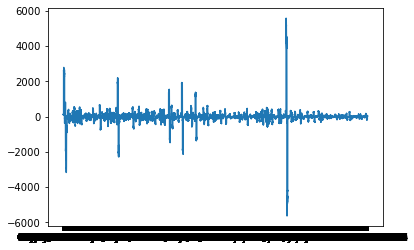

In [47]:
# Momentum for 90 day period
mom = talib.MOM(df_stock_data['Adj Close'],timeperiod=90)
plt.plot(mom)


In [ ]:
# I keep getting key errors when calling multiple columns in the dataframe for the indicator's fundction. Looked up answe to  key erros 
# found the following result on stack overlfow https://stackoverflow.com/questions/52873892/getting-keyerror-adj-close-in-python:
    #Keyerrors are what you get when referring to a dict() like object and no key can be found in dict.

In [55]:
# Average Directional Movement
adx = talib.ADX(df_stock_data['High'],['Low'],['Adj Close'],timeperiod=90)

plt.plot(adx)

TypeError: Argument 'low' has incorrect type (expected numpy.ndarray, got list)

In [56]:
# Normalized Average True Range for 90 day period
natr = talib.NATR(df_stock_data['High'],['Low'],['Adj Close'],timeperiod=90)

plt.plot(natr)

TypeError: Argument 'low' has incorrect type (expected numpy.ndarray, got list)

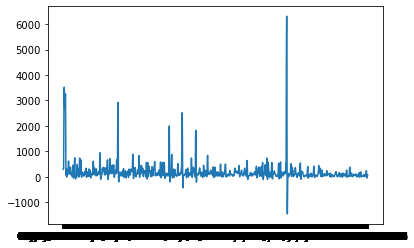

In [44]:
# Linear Regression for 90 day period
linreg = LINEARREG(df_stock_data['Adj Close'], timeperiod=90)

plt.plot(linreg)

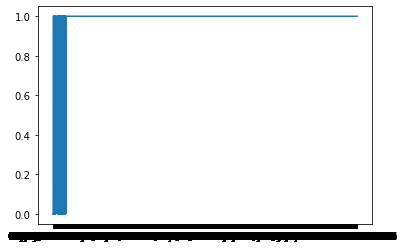

In [51]:
# Hilbert Transform Trend vs Cycle Mode
httrend = talib.HT_TRENDMODE(df_stock_data['Adj Close'])

plt.plot(httrend)


In [46]:
# Relative Strength for 90 day period
# tried running this function as rsi = RSI(df_stock_data['Adj Close'], timeperiod=90) and got the same error that "name 'RSI' is not defined"
# rewrote it as follows because adding talib. on other indicators ran the function and eliminated the "name not defined error"

rsi = talib.RSI(df_stock_data['Adj Close'], timeperiod=90)

plt.plot(rsi)

NameError: name 'RSI' is not defined

In [53]:
# MFI- Money Flow Index
mfi = talib.MFI(df_stock_data['High','Low','Adj Close','Volume'],timeperiod=90)

plt.plot(mfi)

KeyError: ('High', 'Low', 'Adj CloseVolume')

In [57]:
# ADOSC-Chaikin A/D Oscillator
# not sure what is the best periods for this indicator. Example form talib documentation has fastperiod=3 and slowperiod=10

adosc = talib.ADOSC(df_stock_data['High'],['Low'],['Adj Close'],['Volume'],fastperiod=3,slowperiod=10)

plt.plot(adosc)

TypeError: Argument 'low' has incorrect type (expected numpy.ndarray, got list)

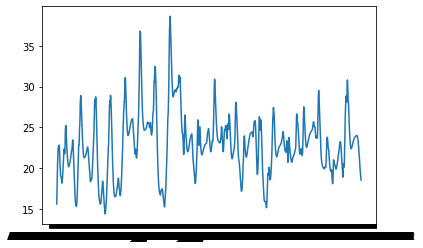

In [59]:
# Cycle Indicators
# Hilbert Transform - Dominant Cycle Period
domcycle= talib.HT_DCPERIOD(df_stock_data['Adj Close'])

plt.plot(domcycle)

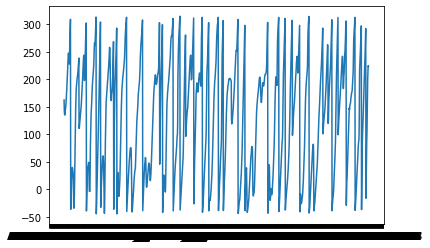

In [61]:
# Cycle Indicators
# Hilbert Transform - Dominant Cycle Phase
dom_cyc_phs = talib.HT_DCPHASE(df_stock_data['Adj Close'])

plt.plot(dom_cyc_phs)